# zkVMs benchmarks

Benchmarks of VM proving times made by Aligned and Lambdaclass

Raw results can be found [here](/bench_results)

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [94]:
## Some auxiliary functions

def time_to_seconds(time_str):
    time_str = time_str.strip()
    try:
        if 'm' in time_str:
            parts = time_str.split('m')
            minutes = float(parts[0])
            seconds = 0
            if len(parts) > 1 and parts[1]:
                seconds = float(parts[1].replace('s', ''))
            return minutes * 60 + seconds
        else:
            return float(time_str.replace('s', ''))
    except Exception as e:
        print(f"Error parsing time: {time_str}")
        print(f"Error details: {e}")
        return None

## Fibonacci Benchmarks

In this section we will analyze the performance of Fibonacci for different provers.

The data was collected on a server with the following specs:
- CPU: AMD EPYC 7543 32-Core Processor
- RAM: 128GB
- OS: Ubuntu 24 LTS

Data loaded from: `bench_results/18_feb_25_epyc7543_32c_128gb.csv`

In [95]:
input_csv_path = 'bench_results/18_feb_25_epyc7543_32c_128gb.csv'

### Load and validate the data

In [96]:
# Read data from CSV
df = pd.read_csv(input_csv_path)
df['N'] = df['N'].astype(int)

### Preprocess the data

We will convert the time to minutes.

In [97]:
for idx, row in df.iterrows():
    seconds = time_to_seconds(row['Time'])

df['Seconds'] = df['Time'].apply(time_to_seconds)
df['Minutes'] = df['Seconds'] / 60

### Print the data sorted by Prover and N

For validation purposes, we will print the data sorted by Prover and N.

In [98]:
# Print sorted data for validation
print("\nData sorted by Prover and N for validation:")
pd.set_option('display.float_format', '{:.2f}'.format)
validation_df = df.sort_values(['Prover', 'N'])[['Prover', 'N', 'Time', 'Minutes']]
print(validation_df.to_string())


Data sorted by Prover and N for validation:
              Prover        N      Time  Minutes
0       Pico Groth16    10000     27.1s     0.45
4       Pico Groth16   100000     42.3s     0.70
8       Pico Groth16  1000000    3m3.9s     3.06
12      Pico Groth16  4000000   11m3.8s    11.06
3              Risc0    10000      9.0s     0.15
7              Risc0   100000     53.3s     0.89
11             Risc0  1000000   8m18.6s     8.31
15             Risc0  4000000  32m21.2s    32.35
1           SP1-AVX2    10000     15.5s     0.26
5           SP1-AVX2   100000     35.7s     0.60
9           SP1-AVX2  1000000    2m2.9s     2.05
13          SP1-AVX2  4000000   6m42.2s     6.70
2   SP1-AVX2-Groth16    10000   1m33.6s     1.56
6   SP1-AVX2-Groth16   100000   1m54.6s     1.91
10  SP1-AVX2-Groth16  1000000   3m20.7s     3.34
14  SP1-AVX2-Groth16  4000000   7m53.7s     7.89


### Plotting the data

We will plot the data in a log-log scale to better visualize the performance of the provers.

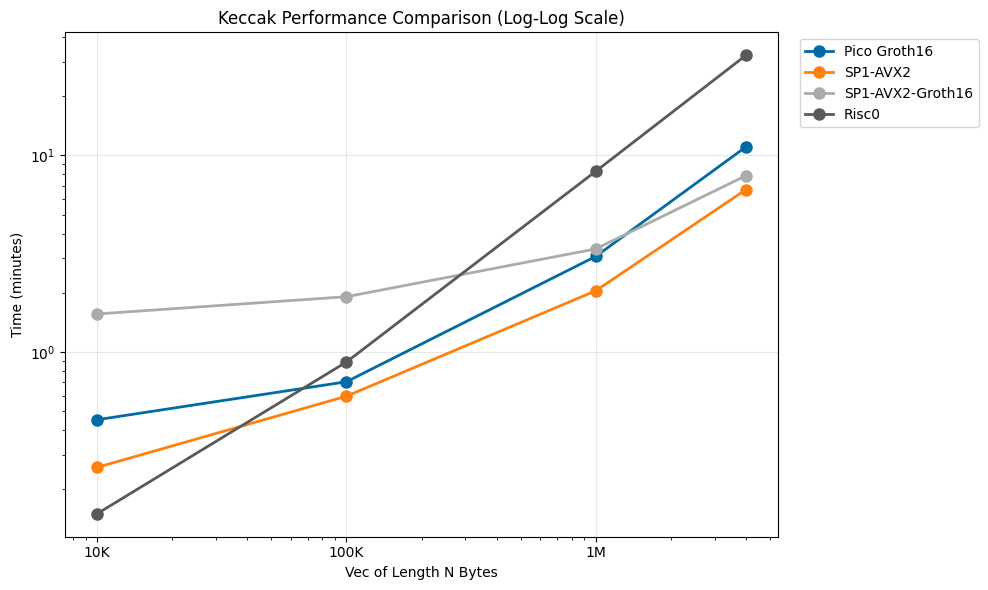

In [99]:
# Set style and color cycle
plt.style.use('tableau-colorblind10')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Create single figure
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Function to plot data
def plot_data(ax, data):
    for i, prover in enumerate(data['Prover'].unique()):
        prover_data = data[data['Prover'] == prover].sort_values('N')
        # print(f"\nPlotting data for {prover}:")
        # print(prover_data[['N', 'Minutes']].to_string())

        ax.loglog(prover_data['N'], prover_data['Minutes'], 'o-',
                 label=prover, linewidth=2, markersize=8,
                 color=colors[i % len(colors)])

# Plot log-log scale
plot_data(ax, df)
ax.set_xlabel('Vec of Length N Bytes')
ax.set_ylabel('Time (minutes)')
ax.set_title(f'Keccak Performance Comparison (Log-Log Scale)')
ax.grid(True, alpha=0.3)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

# Format x-axis to show numbers in millions/thousands
def format_func(x, p):
    if x >= 1_000_000:
        millions = x / 1_000_000
        if millions.is_integer():
            return f'{int(millions)}M'
        else:
            return f'{millions:.1f}M'
    elif x >= 1_000:
        return f'{int(x/1_000)}K'
    return str(int(x))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_func))

plt.tight_layout()

plt.show()

## Keccack Benchmarks

In this section we will analyze the performance of Keccak for different provers.

The data was collected on a server with the following specs:
- CPU: AMD EPYC 7543 32-Core Processor
- RAM: 128GB
- OS: Ubuntu 24 LTS

Data loaded from: `bench_results/keccak_20_feb_25_epyc7543_32c_128gb.csv`

In [100]:
input_csv_path = 'bench_results/keccak_20_feb_25_epyc7543_32c_128gb.csv'

### Load and validate the data

In [101]:
# Read data from CSV
df = pd.read_csv(input_csv_path)
df['N'] = df['N'].astype(int)

### Preprocess the data

We will convert the time to minutes.

In [102]:
for idx, row in df.iterrows():
    seconds = time_to_seconds(row['Time'])

df['Seconds'] = df['Time'].apply(time_to_seconds)
df['Minutes'] = df['Seconds'] / 60

### Print the data sorted by Prover and N

For validation purposes, we will print the data sorted by Prover and N.

In [103]:
# Print sorted data for validation
print("\nData sorted by Prover and N for validation:")
pd.set_option('display.float_format', '{:.2f}'.format)
validation_df = df.sort_values(['Prover', 'N'])[['Prover', 'N', 'Time', 'Minutes']]
print(validation_df.to_string())


Data sorted by Prover and N for validation:
              Prover        N      Time  Minutes
0       Pico Groth16       32     32.8s     0.55
4       Pico Groth16       64     33.0s     0.55
8       Pico Groth16      128     32.8s     0.55
12      Pico Groth16      256     32.9s     0.55
16      Pico Groth16      512     33.0s     0.55
20      Pico Groth16     1024     33.1s     0.55
24      Pico Groth16     4096     33.3s     0.55
28      Pico Groth16    32768     36.9s     0.61
32      Pico Groth16    65536     40.8s     0.68
36      Pico Groth16   262144    1m4.6s     1.08
40      Pico Groth16  1048576   2m57.7s     2.96
44      Pico Groth16  2097152   5m21.1s     5.35
47      Pico Groth16  4194304  10m11.1s    10.19
3              Risc0       32     21.9s     0.36
7              Risc0       64     21.8s     0.36
11             Risc0      128     21.9s     0.36
15             Risc0      256     21.9s     0.36
19             Risc0      512     21.9s     0.36
23             Risc0    

### Plotting the data

We will plot the data in a log-log scale to better visualize the performance of the provers.

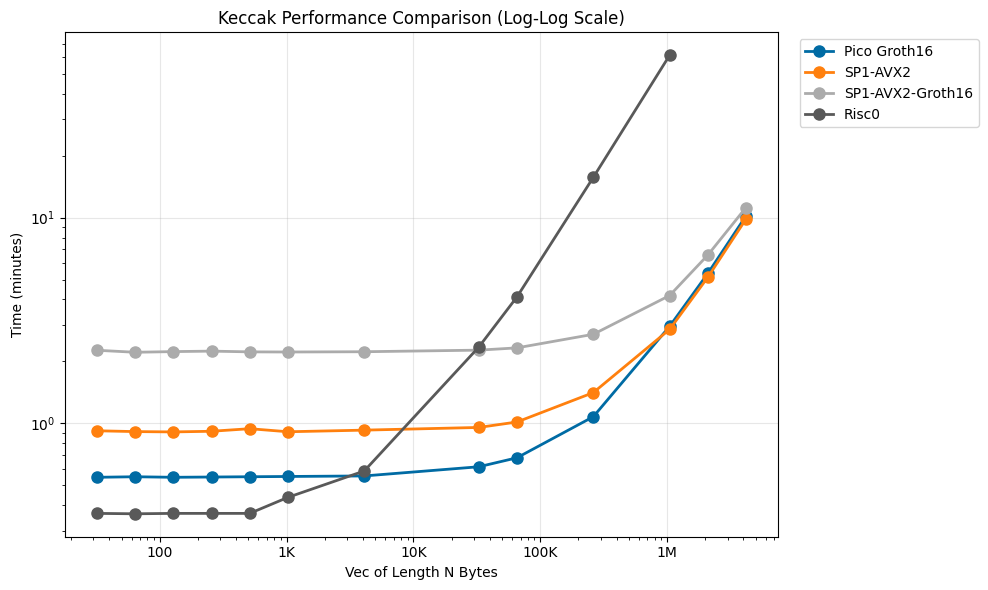

In [104]:
# Set style and color cycle
plt.style.use('tableau-colorblind10')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Create single figure
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Function to plot data
def plot_data(ax, data):
    for i, prover in enumerate(data['Prover'].unique()):
        prover_data = data[data['Prover'] == prover].sort_values('N')
        # print(f"\nPlotting data for {prover}:")
        # print(prover_data[['N', 'Minutes']].to_string())

        ax.loglog(prover_data['N'], prover_data['Minutes'], 'o-',
                 label=prover, linewidth=2, markersize=8,
                 color=colors[i % len(colors)])

# Plot log-log scale
plot_data(ax, df)
ax.set_xlabel('Vec of Length N Bytes')
ax.set_ylabel('Time (minutes)')
ax.set_title(f'Keccak Performance Comparison (Log-Log Scale)')
ax.grid(True, alpha=0.3)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

# Format x-axis to show numbers in millions/thousands
def format_func(x, p):
    if x >= 1_000_000:
        millions = x / 1_000_000
        if millions.is_integer():
            return f'{int(millions)}M'
        else:
            return f'{millions:.1f}M'
    elif x >= 1_000:
        return f'{int(x/1_000)}K'
    return str(int(x))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_func))

plt.tight_layout()

plt.show()